# Modelagem

Inicialmente, o conjunto de dados foi dividido em conjuntos de treinamento e teste por meio de amostragem estratificada. O conjunto de teste foi isolado antes de qualquer etapa de pré-processamento. 

Todas as etapas de transformação, balanceamento, seleção de algoritmo e ajuste de hiperparâmetros foram realizadas exclusivamente no conjunto de treinamento utilizando validação cruzada estratificada. O modelo final foi então treinado com todos os dados de treinamento e avaliado uma única vez no conjunto de teste.

### Fluxograma do Pipeline de Dados

```text
       ┌──────────────────────────────────────────┐
       │     Dataset original (desbalanceado)     │
       │            ~10.000 registros             │
       └──────────────────────────────────────────┘
                     │
                     │ (Split estratificado)
                     ▼
       ┌──────────────────────────┐      ┌──────────────────────────────────────────┐
       │     Conjunto de Teste    │      │         Conjunto de Treinamento          │
       │   (~20% | ~2.000 reg.)   │◄─────┤           (~80% | ~8.000 reg.)           │
       │  ❌ Sem pré-processamento │      └──────────────────────────────────────────┘
       │  ❌ Sem balanceamento     │                    │
       └─────────────┬────────────┘                    ▼
                     │                 ┌──────────────────────────┐
                     │                 │     Pré-processamento    │
                     │                 │ (scaler, encoder, etc.)  │
                     │                 │   ✔ fit apenas no treino │
                     │                 └──────────────────────────┘
                     │                                 │
                     │                                 ▼
                     │                 ┌──────────────────────────┐
                     │                 │      Balanceamento       │
                     │                 │          (Under)         │
                     │                 │  ❗ apenas no treino     │
                     │                 └──────────────────────────┘
                     │                                 │
                     │                                 ▼
                     │                 ┌──────────────────────────┐
                     │                 │     Validação Cruzada    │
                     │                 │    (Stratified K-Fold)   │
                     │                 │                          │
                     │                 │ • Comparar algoritmos    │
                     │                 │ • Ajustar hiperparâmetros│
                     │                 │ • Estimar desempenho     │
                     │                 └──────────────────────────┘
                     │                                 │
                     │                                 ▼
                     │                 ┌──────────────────────────┐
                     │                 │  Modelo final escolhido  │
                     │                 │ (melhor algoritmo +      │
                     │                 │   melhores parâmetros)   │
                     │                 └──────────────────────────┘
                     │                                 │
                     │                                 ▼
                     │                 ┌──────────────────────────┐
                     │                 │     Treinamento final    │
                     │                 │      (100% do treino)    │
                     │                 │      ❌ sem CV           │
                     │                 └──────────────────────────┘
                     │                                 │
                     ▼                                 ▼
       ┌──────────────────────────────────────────────────────────┐
       │                 Avaliação final no teste                 │
       │ • Métricas reais (Precisão, AUC, curva ROC,              |
       | sensibilidade e especificidade)                          │
       │ • Validação de Generalização                             │
       │ • Executado uma única vez                                │
       └──────────────────────────────────────────────────────────┘

### Separando conjunto de teste e de treinamento

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

from utils.general import *
from utils.norm_test import *
from utils.pre_process import *
from utils.analise_estatistica  import *

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = catchPath('data/data.xlsx')
data_path

'/ML/data/data.xlsx'

In [4]:
df = pd.read_excel(data_path)
df.head()

,ID_Cliente,Status_Cliente,Idade,Genero,Numero_Dependentes,Nivel_Educacao,Estado_Civil,Faixa_Renda,Categoria_Cartao,Meses_Relacionamento,...,Contatos_12m,Limite_Credito,Saldo_Rotativo,Limite_Disponivel,Variacao_Valor_Transacoes,Valor_Total_Transacoes,Quantidade_Transacoes,Variacao_Qtd_Transacoes,Taxa_Utilizacao_Credito,classe
0,768805383,Cliente Ativo,45,Masculino,3,Ensino Médio,Casado,60k a 80k,Azul,39,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1
1,818770008,Cliente Ativo,49,Feminino,5,Graduação,Solteiro,Menos de 40k,Azul,44,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1
2,713982108,Cliente Ativo,51,Masculino,3,Graduação,Casado,80k a 120k,Azul,36,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,1
3,769911858,Cliente Ativo,40,Feminino,4,Ensino Médio,Não Informado,Menos de 40k,Azul,34,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,1
4,709106358,Cliente Ativo,40,Masculino,3,Sem Escolaridade,Casado,60k a 80k,Azul,21,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,1


In [5]:
df.shape

(10127, 22)

### Tabela Final de Decisão de Features

| Variável | Evidência Estatística | Correlação | Decisão |
|--|--|--|--|
| Quantidade_Transacoes | Forte | Alta com Valor_Total | Manter |
| Taxa_Utilizacao_Credito | Moderada | Baixa | Manter |
| Meses_Inativos_12m | Moderada | Baixa | Manter |
| Variacao_Qtd_Transacoes | Significativa | Baixa | Manter |
| Variacao_Valor_Transacoes | Significativa | Baixa | Manter |
| Valor_Total_Transacoes | Moderada | Alta | Substituir |
| Limite_Credito | Fraca | Moderada | Opcional |
| Idade | Não significativa | — | Remover |


In [6]:
df.columns

Index(['ID_Cliente', 'Status_Cliente', 'Idade', 'Genero', 'Numero_Dependentes',
       'Nivel_Educacao', 'Estado_Civil', 'Faixa_Renda', 'Categoria_Cartao',
       'Meses_Relacionamento', 'Total_Produtos', 'Meses_Inativos_12m',
       'Contatos_12m', 'Limite_Credito', 'Saldo_Rotativo', 'Limite_Disponivel',
       'Variacao_Valor_Transacoes', 'Valor_Total_Transacoes',
       'Quantidade_Transacoes', 'Variacao_Qtd_Transacoes',
       'Taxa_Utilizacao_Credito', 'classe'],
      dtype='object')

In [7]:
features = [
    'Quantidade_Transacoes',
    'Taxa_Utilizacao_Credito',
    'Meses_Inativos_12m',
    'Variacao_Qtd_Transacoes',
    'Variacao_Valor_Transacoes'    
]

In [8]:
X = df[features].copy()
X.shape

(10127, 5)

In [9]:
y = df['classe'].copy()
y.shape

(10127,)

In [10]:
# split ANTES do balanceamento
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=2
)

In [11]:
X_test.shape

(2026, 5)

In [12]:
X_test.head()

,Quantidade_Transacoes,Taxa_Utilizacao_Credito,Meses_Inativos_12m,Variacao_Qtd_Transacoes,Variacao_Valor_Transacoes
2671,39,0.000,0,0.345,0.604
1888,61,0.037,4,0.743,0.889
6971,49,0.000,4,1.227,1.007
9082,106,0.000,3,0.767,0.947
5576,68,0.217,1,0.700,0.646


In [13]:
teste = X_test.copy()

In [14]:
teste['classe'] = y_test.copy()

In [18]:
y_test

2671    0
1888    1
6971    1
9082    1
5576    1
       ..
2286    1
550     1
857     1
9507    1
377     1
Name: classe, Length: 2026, dtype: int64

In [16]:
teste.head()

,Quantidade_Transacoes,Taxa_Utilizacao_Credito,Meses_Inativos_12m,Variacao_Qtd_Transacoes,Variacao_Valor_Transacoes,classe
2671,39,0.000,0,0.345,0.604,0
1888,61,0.037,4,0.743,0.889,1
6971,49,0.000,4,1.227,1.007,1
9082,106,0.000,3,0.767,0.947,1
5576,68,0.217,1,0.700,0.646,1


In [17]:
teste.shape

(2026, 6)

In [20]:
SaveDataFrame(teste,'Grupo_teste')

In [21]:
treino = X_train.copy()

In [22]:
treino['classe'] = y_train.copy()

In [23]:
treino.head()

,Quantidade_Transacoes,Taxa_Utilizacao_Credito,Meses_Inativos_12m,Variacao_Qtd_Transacoes,Variacao_Valor_Transacoes,classe
2607,52,0.619,1,0.857,0.612,1
5418,50,0.000,3,0.923,0.602,0
2684,73,0.036,2,0.698,0.739,1
1345,42,0.000,1,0.750,0.782,1
4298,39,0.000,2,0.345,0.637,0


In [24]:
treino.shape

(8101, 6)

In [25]:
SaveDataFrame(treino,'Grupo_treino')

In [3]:
# determinando o nivel de confiança para a amostra de teste com um erro de 2%
df_validacao = calcular_confianca_amostral(N=10127, n=2026, e=0.02)
print(df_validacao)

                Parâmetro          Valor
0     População Total (N)         10.127
1  Tamanho da Amostra (n)  2.026 (20.0%)
2      Margem de Erro (e)           2.0%
3      Escore-Z calculado           2.01
4      Nível de Confiança          95.6%


A amostragem para construir o conjunto de dados para realizar os testes foi validado estatisticamente demonstrando representatividade. Para uma população total de $N = 10.127$, a amostra de teste selecionada de $n = 2.026$ (20% do dataset) resulta em um nível de confiança de aproximadamente 95,5%, com uma margem de erro estrita de apenas 2%.

# Balanciamento

In [3]:
path_treino = catchPath('data/Grupo_treino.xlsx')
path_treino

'/ML/data/Grupo_treino.xlsx'

In [4]:
df2 = pd.read_excel(path_treino)
df2.head()

,Quantidade_Transacoes,Taxa_Utilizacao_Credito,Meses_Inativos_12m,Variacao_Qtd_Transacoes,Variacao_Valor_Transacoes,classe
0,52,0.619,1,0.857,0.612,1
1,50,0.000,3,0.923,0.602,0
2,73,0.036,2,0.698,0.739,1
3,42,0.000,1,0.750,0.782,1
4,39,0.000,2,0.345,0.637,0


In [5]:
df2.columns

Index(['Quantidade_Transacoes', 'Taxa_Utilizacao_Credito',
       'Meses_Inativos_12m', 'Variacao_Qtd_Transacoes',
       'Variacao_Valor_Transacoes', 'classe'],
      dtype='object')

In [6]:
col = ['Quantidade_Transacoes', 'Taxa_Utilizacao_Credito',
       'Meses_Inativos_12m', 'Variacao_Qtd_Transacoes',
       'Variacao_Valor_Transacoes']

In [7]:
x1 = df2[col].copy()

In [11]:
x1.shape

(8101, 5)

In [8]:
y1 = df2['classe'].copy()

In [12]:
y1.shape

(8101,)

In [10]:
y1.value_counts()

classe
1    6799
0    1302
Name: count, dtype: int64

In [13]:
X_resampled, y_resampled = balances_categories(x1, y1)

In [14]:
X_resampled.shape

(2604, 5)

In [15]:
y_resampled.value_counts()

classe
0    1302
1    1302
Name: count, dtype: int64

In [16]:
df_balance = X_resampled.copy()
df_balance.head()

,Quantidade_Transacoes,Taxa_Utilizacao_Credito,Meses_Inativos_12m,Variacao_Qtd_Transacoes,Variacao_Valor_Transacoes
1,50,0.000,3,0.923,0.602
4,39,0.000,2,0.345,0.637
13,40,0.000,3,0.212,0.399
30,47,0.000,2,0.469,0.367
38,44,0.983,2,0.467,0.850


In [17]:
df_balance['classe'] = y_resampled
df_balance.head()

,Quantidade_Transacoes,Taxa_Utilizacao_Credito,Meses_Inativos_12m,Variacao_Qtd_Transacoes,Variacao_Valor_Transacoes,classe
1,50,0.000,3,0.923,0.602,0
4,39,0.000,2,0.345,0.637,0
13,40,0.000,3,0.212,0.399,0
30,47,0.000,2,0.469,0.367,0
38,44,0.983,2,0.467,0.850,0


In [18]:
SaveDataFrame(df_balance,'Grupo_treino_Balanceado')

In [19]:
df_balance.shape

(2604, 6)

In [55]:
# determinando o nivel de confiança para a amostra de teste com um erro de 2%
df_validacao = calcular_confianca_amostral(N=8101, n=2604, e=0.02)
print(df_validacao)

                Parâmetro          Valor
0     População Total (N)          8.101
1  Tamanho da Amostra (n)  2.604 (32.1%)
2      Margem de Erro (e)           2.0%
3      Escore-Z calculado           2.48
4      Nível de Confiança          98.7%


Optou-se pelo do metodo de under sampling, e obtivemos um grupo de treinamento  com classes balanceadas com um total de 2604 registros, essa nova subamostragem é representativa com uma margem de erro de 2% com nivel de confiança de 98,7%.

# Escolha dos métodos de Machine Learning

In [20]:
path_t_balance = catchPath('data/Grupo_treino_Balanceado.xlsx')
path_t_balance

'/ML/data/Grupo_treino_Balanceado.xlsx'

In [21]:
df3 =  pd.read_excel(path_t_balance)
df3.head()

,Quantidade_Transacoes,Taxa_Utilizacao_Credito,Meses_Inativos_12m,Variacao_Qtd_Transacoes,Variacao_Valor_Transacoes,classe
0,50,0.000,3,0.923,0.602,0
1,39,0.000,2,0.345,0.637,0
2,40,0.000,3,0.212,0.399,0
3,47,0.000,2,0.469,0.367,0
4,44,0.983,2,0.467,0.850,0


In [22]:
df3.shape

(2604, 6)

In [23]:
df3['classe'].value_counts()

classe
0    1302
1    1302
Name: count, dtype: int64

In [24]:
import pandas as pd
from sklearn.model_selection import cross_validate, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [25]:
# 1. Configuração inicial
modelos_nomes = ['naive_bayes', 'logistica', 'forest', 'svm']
resultados = {nome: {'acc': [], 'auc': []} for nome in modelos_nomes}
metrics = ['accuracy', 'roc_auc']

In [26]:
df3.columns

Index(['Quantidade_Transacoes', 'Taxa_Utilizacao_Credito',
       'Meses_Inativos_12m', 'Variacao_Qtd_Transacoes',
       'Variacao_Valor_Transacoes', 'classe'],
      dtype='object')

In [28]:
c = ['Quantidade_Transacoes', 'Taxa_Utilizacao_Credito',
       'Meses_Inativos_12m', 'Variacao_Qtd_Transacoes',
       'Variacao_Valor_Transacoes']

In [29]:
X = df3[c].copy()

In [30]:
X.head()

,Quantidade_Transacoes,Taxa_Utilizacao_Credito,Meses_Inativos_12m,Variacao_Qtd_Transacoes,Variacao_Valor_Transacoes
0,50,0.000,3,0.923,0.602
1,39,0.000,2,0.345,0.637
2,40,0.000,3,0.212,0.399
3,47,0.000,2,0.469,0.367
4,44,0.983,2,0.467,0.850


In [31]:
y = df3['classe'].copy()

In [32]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: classe, dtype: int64

In [33]:
X.shape

(2604, 5)

In [34]:
y.shape

(2604,)

In [35]:
# 2. Loop de Processamento (30 rodadas)
for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    lista_modelos = [
        ('naive_bayes', GaussianNB()),
        ('logistica', Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000))])),
        ('forest', RandomForestClassifier()),
        ('svm', Pipeline([('scaler', StandardScaler()), ('model', SVC(probability=True))]))
    ]

    for nome, modelo in lista_modelos:
        scores = cross_validate(modelo, X, y, cv=kfold, scoring=metrics)
        resultados[nome]['acc'].append(scores['test_accuracy'].mean())
        resultados[nome]['auc'].append(scores['test_roc_auc'].mean())

In [36]:
# 3. Compilando o resultado em um dataframe 
df_completo = pd.DataFrame({
    (mod, met): resultados[mod][met]
    for mod in resultados.keys()
    for met in resultados[mod].keys()
})
df_completo.columns = pd.MultiIndex.from_tuples(df_completo.columns, names=['Modelo', 'Métrica'])

In [37]:
df_completo.head()

Modelo  naive_bayes           logistica              forest            \
Métrica         acc       auc       acc       auc       acc       auc   
0          0.789195  0.868364  0.782278  0.858591  0.842953  0.914913   
1          0.791870  0.868927  0.781116  0.859281  0.841410  0.913341   
2          0.793425  0.869481  0.779592  0.858388  0.836040  0.912963   
3          0.793416  0.868201  0.781505  0.857846  0.837567  0.914166   
4          0.790321  0.868641  0.781872  0.858915  0.837548  0.913440   

Modelo        svm            
Métrica       acc       auc  
0        0.833733  0.907501  
1        0.834499  0.906602  
2        0.836804  0.907149  
3        0.835644  0.906715  
4        0.837552  0.908136

In [38]:
df_completo.mean()

Modelo       Métrica
naive_bayes  acc        0.791236
             auc        0.868958
logistica    acc        0.780840
             auc        0.859025
forest       acc        0.839429
             auc        0.914873
svm          acc        0.835205
             auc        0.907973
dtype: float64

In [40]:
# 4. Exportação para Excel

df_estatisticas = df_completo.describe()

with pd.ExcelWriter('resultados_machine_learning.xlsx') as writer:
    df_completo.to_excel(writer, sheet_name='Dados_Brutos_30_Rodadas')
    df_estatisticas.to_excel(writer, sheet_name='Resumo_Estatistico')

print("Arquivo 'resultados_machine_learning.xlsx' gerado com sucesso!")

Arquivo 'resultados_machine_learning.xlsx' gerado com sucesso!


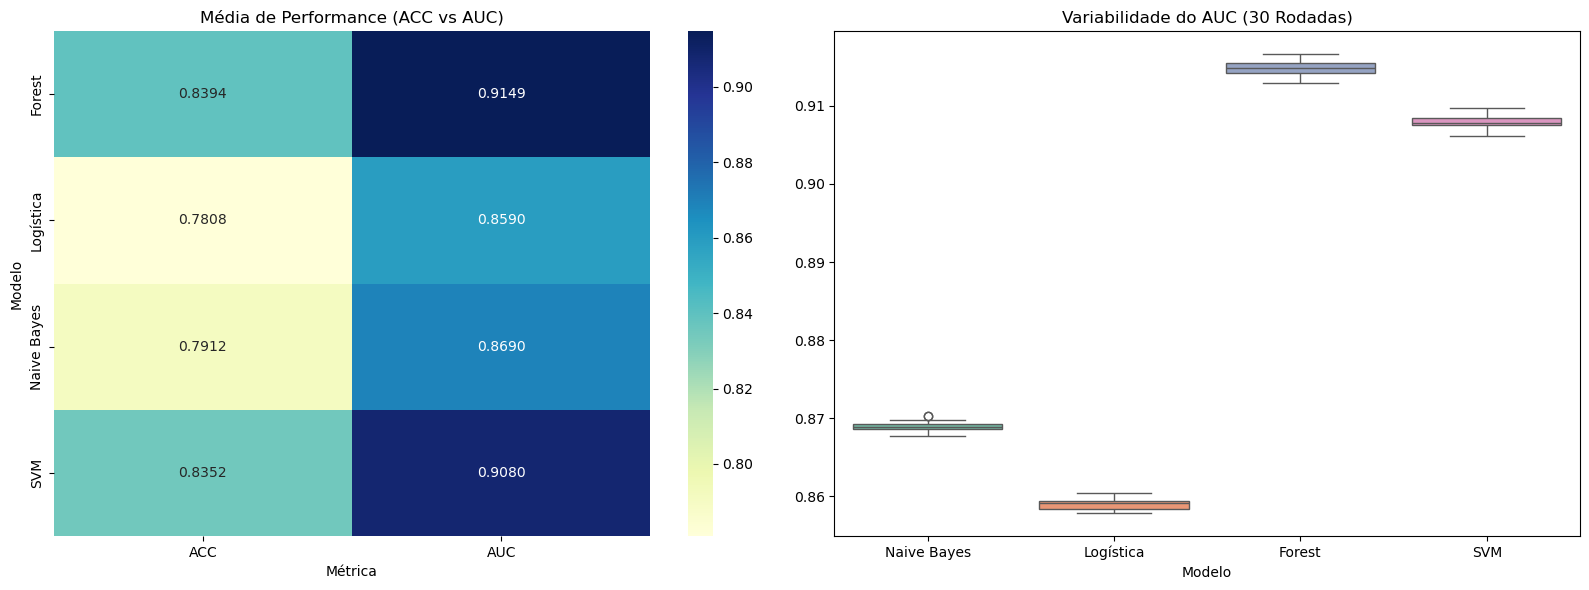

In [42]:
df_completo = pd.DataFrame({
    ('Naive Bayes', 'ACC'): resultados['naive_bayes']['acc'],
    ('Naive Bayes', 'AUC'): resultados['naive_bayes']['auc'],
    ('Logística', 'ACC'): resultados['logistica']['acc'],
    ('Logística', 'AUC'): resultados['logistica']['auc'],
    ('Forest', 'ACC'): resultados['forest']['acc'],
    ('Forest', 'AUC'): resultados['forest']['auc'],
    ('SVM', 'ACC'): resultados['svm']['acc'],
    ('SVM', 'AUC'): resultados['svm']['auc']
}) #padronizando os rótolos

# 2. 
df_completo.columns = pd.MultiIndex.from_tuples(df_completo.columns, names=['Modelo', 'Métrica'])

# 3. 
import seaborn as sns
import matplotlib.pyplot as plt

df_medias = df_completo.mean().unstack()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Calor (Média)
sns.heatmap(df_medias, annot=True, cmap='YlGnBu', fmt='.4f', ax=ax[0])
ax[0].set_title('Média de Performance (ACC vs AUC)')

# Boxplot (Variação) - 
df_auc_only = df_completo.xs('AUC', axis=1, level='Métrica')
sns.boxplot(data=df_auc_only, ax=ax[1], palette='Set2')
ax[1].set_title('Variabilidade do AUC (30 Rodadas)')

plt.tight_layout()
plt.show()

In [43]:
df_completo.head()

Modelo  Naive Bayes           Logística              Forest            \
Métrica         ACC       AUC       ACC       AUC       ACC       AUC   
0          0.789195  0.868364  0.782278  0.858591  0.842953  0.914913   
1          0.791870  0.868927  0.781116  0.859281  0.841410  0.913341   
2          0.793425  0.869481  0.779592  0.858388  0.836040  0.912963   
3          0.793416  0.868201  0.781505  0.857846  0.837567  0.914166   
4          0.790321  0.868641  0.781872  0.858915  0.837548  0.913440   

Modelo        SVM            
Métrica       ACC       AUC  
0        0.833733  0.907501  
1        0.834499  0.906602  
2        0.836804  0.907149  
3        0.835644  0.906715  
4        0.837552  0.908136

In [44]:
df_estatisticas = df_completo.describe()

with pd.ExcelWriter('resultados_machine_learning_.xlsx') as writer:
    df_completo.to_excel(writer, sheet_name='Dados_Brutos_30_Rodadas')
    df_estatisticas.to_excel(writer, sheet_name='Resumo_Estatistico')

print("Arquivo 'resultados_machine_learning.xlsx' gerado com sucesso!")

Arquivo 'resultados_machine_learning.xlsx' gerado com sucesso!


In [45]:
# Filtramos apenas as colunas de AUC
df_auc = df_completo.xs('AUC', axis=1, level='Métrica')

            Estatística   p-valor Distribuição Normal?
Naive Bayes    0.981965  0.875041                  Sim
Logística      0.971768  0.588605                  Sim
Forest         0.984453   0.92752                  Sim
SVM            0.973894  0.650176                  Sim


In [49]:
df_auc.head()

Modelo,Naive Bayes,Logística,Forest,SVM
0,0.868364,0.858591,0.914913,0.907501
1,0.868927,0.859281,0.913341,0.906602
2,0.869481,0.858388,0.912963,0.907149
3,0.868201,0.857846,0.914166,0.906715
4,0.868641,0.858915,0.913440,0.908136


In [51]:
df_auc.shape

(30, 4)

In [53]:
df_auc.mean()

Modelo
Naive Bayes    0.868958
Logística      0.859025
Forest         0.914873
SVM            0.907973
dtype: float64

In [52]:
df_auc.std()

Modelo
Naive Bayes    0.000590
Logística      0.000638
Forest         0.000928
SVM            0.000890
dtype: float64

In [56]:
SaveDataFrame(df_auc,'Resultados_Modelos_Metrica_AUC')

In [50]:
# Filtramos apenas as colunas de ACC
df_acc = df_completo.xs('ACC', axis=1, level='Métrica')
df_acc.head()

Modelo,Naive Bayes,Logística,Forest,SVM
0,0.789195,0.782278,0.842953,0.833733
1,0.791870,0.781116,0.841410,0.834499
2,0.793425,0.779592,0.836040,0.836804
3,0.793416,0.781505,0.837567,0.835644
4,0.790321,0.781872,0.837548,0.837552


In [54]:
df_acc.mean()

Modelo
Naive Bayes    0.791236
Logística      0.780840
Forest         0.839429
SVM            0.835205
dtype: float64

In [55]:
df_acc.std()

Modelo
Naive Bayes    0.001253
Logística      0.001111
Forest         0.002336
SVM            0.001545
dtype: float64

In [57]:
SaveDataFrame(df_acc,'Resultados_Modelos_Metrica_ACC')

### Testando Normalidade

In [46]:
from scipy.stats import shapiro
import pandas as pd

def testar_normalidade(df, metrica='AUC'):
    """
    Realiza o teste de Shapiro-Wilk para todos os modelos de uma métrica específica.
    """
    # 1. Extrai apenas a métrica desejada usando cross-section (xs)
    try:
        dados_metrica = df.xs(metrica, axis=1, level='Métrica')
    except KeyError:
        return f"Erro: A métrica '{metrica}' não foi encontrada no DataFrame."

    resultados = []

    # 2. Loop pelos modelos (colunas)
    for modelo in dados_metrica.columns:
        stat, p_valor = shapiro(dados_metrica[modelo])
        
        # Interpretando o p-valor (alfa de 0.05)
        dist_normal = "Sim" if p_valor > 0.05 else "Não"
        
        resultados.append({
            'Modelo': modelo,
            'Métrica': metrica,
            'Estatística W': round(stat, 4),
            'p-valor': round(p_valor, 4),
            'Normal?': dist_normal
        })

    # 3. Retorna um DataFrame organizado
    return pd.DataFrame(resultados).set_index('Modelo')

In [47]:
# Para AUC
df_norm_auc = testar_normalidade(df_completo, metrica='AUC')
print("Teste de Normalidade para AUC:")
print(df_norm_auc)

print("\n" + "-"*30 + "\n")

Teste de Normalidade para AUC:
            Métrica  Estatística W  p-valor Normal?
Modelo                                             
Naive Bayes     AUC         0.9820   0.8750     Sim
Logística       AUC         0.9718   0.5886     Sim
Forest          AUC         0.9845   0.9275     Sim
SVM             AUC         0.9739   0.6502     Sim

------------------------------



In [48]:
# Para ACC
df_norm_acc = testar_normalidade(df_completo, metrica='ACC')
print("Teste de Normalidade para ACC:")
print(df_norm_acc)

Teste de Normalidade para ACC:
            Métrica  Estatística W  p-valor Normal?
Modelo                                             
Naive Bayes     ACC         0.9683   0.4933     Sim
Logística       ACC         0.9621   0.3503     Sim
Forest          ACC         0.9738   0.6469     Sim
SVM             ACC         0.9708   0.5607     Sim


In [66]:
from scipy import stats

def executar_anova_auc(caminho_arquivo):
    """
    Responsabilidade: Carregar os dados de AUC e calcular a ANOVA de uma via.
    """
    # Carrega os dados (considerando que o CSV veio do seu Excel de AUC)
    df = pd.read_excel(caminho_arquivo)
    
    # Prepara os grupos: cada coluna vira uma lista de valores para o teste
    # Ex: grupos = [coluna_NB, coluna_Log, coluna_Forest, coluna_SVM]
    grupos = [df[coluna].values for coluna in df.columns]
    
    # Calcula a ANOVA de uma via (One-way ANOVA)
    f_stat, p_valor = stats.f_oneway(*grupos)
    
    return f_stat, p_valor

In [65]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def executar_tukey_auc(caminho_arquivo, alfa=0.05):
    """
    Responsabilidade: Transformar os dados para formato longo e 
    realizar a comparação par a par de Tukey.
    """
    # 1. Carrega os dados originais (formato largo)
    df = pd.read_excel(caminho_arquivo)
    
    # 2. Transforma para formato longo (necessário para o statsmodels)
    # De: [NB, Log, Forest] -> Para: [Modelo, Valor]
    df_longo = df.melt(var_name='Modelo', value_name='AUC')
    
    # 3. Realiza o teste de Tukey
    resultado_tukey = pairwise_tukeyhsd(endog=df_longo['AUC'], 
                                        groups=df_longo['Modelo'], 
                                        alpha=alfa)
    
    return resultado_tukey

In [61]:
arquivo = catchPath('data/Resultados_Modelos_Metrica_AUC.xlsx')
arquivo

'/ML/data/Resultados_Modelos_Metrica_AUC.xlsx'

In [ ]:
executar_anova_auc

In [67]:
# Passo 1: Avaliar se há diferença global
f, p = executar_anova_auc(arquivo)

print(f"=== RESULTADO ANOVA ===")
print(f"p-valor: {p:.4e}")

if p < 0.05:
    print("\n[!] Diferença significativa detectada. Iniciando Teste de Tukey...\n")
    # Passo 2: Comparação par a par
    resultado_final = executar_tukey_auc(arquivo)
    print(resultado_final)
else:
    print("\n[✓] Não há diferença estatística entre os modelos (p >= 0.05).")

=== RESULTADO ANOVA ===
p-valor: 9.3110e-174

[!] Diferença significativa detectada. Iniciando Teste de Tukey...

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
     Forest   Logística  -0.0558   0.0 -0.0564 -0.0553   True
     Forest Naive Bayes  -0.0459   0.0 -0.0464 -0.0454   True
     Forest         SVM  -0.0069   0.0 -0.0074 -0.0064   True
  Logística Naive Bayes   0.0099   0.0  0.0094  0.0105   True
  Logística         SVM   0.0489   0.0  0.0484  0.0495   True
Naive Bayes         SVM    0.039   0.0  0.0385  0.0395   True
-------------------------------------------------------------


A análise estatística através do teste de Tukey (com $\alpha=0.05$) confirmou que o modelo Random Forest apresentou o melhor desempenho de classificação (AUC médio de 0.914), superando de forma estatisticamente significativa todos os demais algoritmos testados ($p < 0.001$). O modelo SVM consolidou-se como a segunda melhor opção, enquanto a Regressão Logística apresentou o menor desempenho médio entre os candidatos.